In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 53.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=a7b3d50f3edd690a99819bc91759807c65311e529c12e9bbf10a27a3cca8856c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


***MOUNT GOOGLE DRIVE WHERE THE ANALYSIS SOURCE (AS TEXT FILES) WILL RESIDE***

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


***LOAD SOURCE FILE FROM DRIVE WITH SCHEMA***

In [8]:
from pyspark.sql import SparkSession, types
import matplotlib.pyplot as plt
import numpy as np

analysis_schema = types.StructType([
        types.StructField('file_name', types.StringType(), nullable=True),
        types.StructField('function_name', types.StringType(), nullable=True),
        types.StructField('description', types.StringType(), nullable=True),
        types.StructField('time_taken', types.FloatType(), nullable=True)
    ])


spark = SparkSession.builder.appName("process dataset").getOrCreate()
df = spark.read.csv("/content/drive/My Drive/performance_analysis.txt", schema=analysis_schema, sep=",")
df.show()


+---------------+--------------------+--------------------+----------+
|      file_name|       function_name|         description|time_taken|
+---------------+--------------------+--------------------+----------+
|read_write_data|       read_data_csv| Load dataframe f...|  2.022549|
|   process_data|  drop_selected_data| Drop data to red...|  1.612916|
|   process_data| map_attack_categ...| Find the attack ...|  0.095926|
|   process_data| process_attack_c...| Perform all atta...| 15.598624|
|   process_data| remove_duplicate...| Remove duplicate...|  0.035989|
|   process_data| load_and_initial...| Perform initialE...| 15.691589|
|   run_training| training_model_f...| Create model fro...|  943.5327|
|   run_training| augment_and_proc...| Augment and proc...| 16.140919|
|   run_training|          save_model| Run the training...|  927.3918|
+---------------+--------------------+--------------------+----------+



This shows the running times of all functions. The flow is, if function_A internally calls function_B, the run time of function_B is added to the run time of function A (because the total time taken by function_A is dependent on function_B's return time).

The initial data size is 5 Million+ records and throughout various ETL and cleaning processes, the number of records for training are 220K+

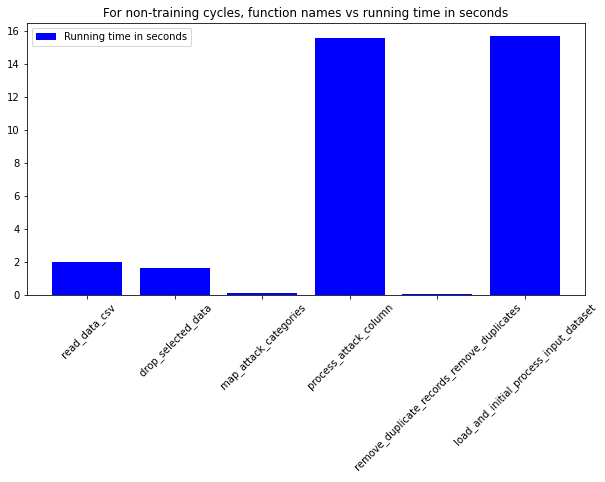

In [9]:
df = df.toPandas()
without_training = df.loc[df['file_name'] != "run_training"]
plt.figure(figsize=(10, 5))
plt.bar(np.array(without_training.iloc[:,1]) , np.array(without_training.iloc[:,3]) , color='blue')
plt.xticks(rotation=45)
plt.title("For non-training cycles, function names vs running time in seconds")
plt.legend(["Running time in seconds"], loc='upper left')
plt.show()


This shows the total running time of the whole training pipeline and the longest stage of the ETL functions.

,file_name,function_name,description,time_taken
6,run_training,training_model_full_data,Create model from full training data,943.532715
8,run_training,save_model,Run the training on full data and save the ge...,927.391785
7,run_training,augment_and_process_data,Augment and process data for training,16.140919
5,process_data,load_and_initial_process_input_dataset,Perform initialETL processing steps,15.691589
3,process_data,process_attack_column,Perform all attack relatedETL operations,15.598624
0,read_write_data,read_data_csv,Load dataframe from the input file,2.022549
1,process_data,drop_selected_data,Drop data to reduce data skew,1.612916
2,process_data,map_attack_categories,Find the attack category from attack type,0.095926
4,process_data,remove_duplicate_records_remove_duplicates,Remove duplicates using drop duplicate method,0.035989


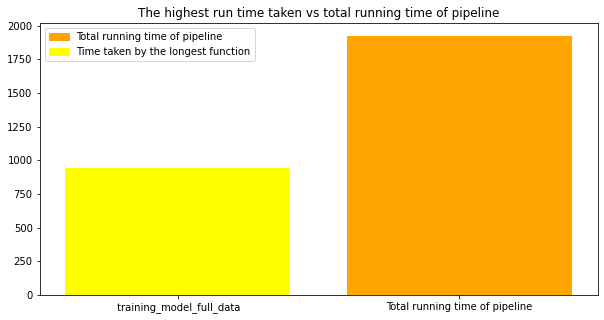

In [10]:
training_cycles = df.sort_values(ascending=False, by="time_taken")
train_time = training_cycles.iloc[0,:]
display(training_cycles)

stage_name = np.array(train_time[1])
time_taken = np.array(train_time[3])

stage_name = np.append([stage_name], ["Total running time of pipeline"])
time_taken = np.append([time_taken], [training_cycles["time_taken"].sum()])

print()
print()

plt.figure(figsize=(10, 5))
plt.bar(stage_name , time_taken , color=['yellow', 'orange'])
plt.title("The highest run time taken vs total running time of pipeline")
handles = [plt.Rectangle((0,0),1,1, color=color_type) for color_type in ['orange', 'yellow']]
plt.legend(handles, ["Total running time of pipeline", "Time taken by the longest function"], loc='upper left')
plt.show()

Convert the spark dataframe to pandas dataframe

In [162]:
df = spark.read.csv("/content/drive/My Drive/static_analysis.txt", schema=analysis_schema, sep=",")
df.show()

compare = df.toPandas()


+---------------+--------------------+--------------------+----------+
|      file_name|       function_name|         description|time_taken|
+---------------+--------------------+--------------------+----------+
|read_write_data|     read_dataset_s3| Read the full un...| 25.890606|
|read_write_data| read_dataset_s3_...| Read the compres...|  2.603271|
|   process_data| remove_duplicate...| Remove duplicate...|  88.36895|
|   process_data| remove_duplicate...| Remove duplicate...| 75.016014|
|   process_data|   get_attack_counts| Materialize the ...|  60.53679|
|   process_data| get_attack_count...| Materialize the ...| 14.454663|
|   process_data| clean_data_distinct| Remove columns w...| 190.25467|
|   process_data| clean_data_witho...| Remove columns w...| 120.25467|
+---------------+--------------------+--------------------+----------+



During ETL, we compared different ways of implementing the same logic and tested them against each other. We recorded the running times of each method separately and decided to keep the efficient of the two. We did these for many functions and chose the pipeline steps carefully. The following graphs signify these analysis one by one.

Reading the compressed version of the file from S3, seemed more efficient than reading the whole data from S3 for processing, which was our first approach.

,file_name,function_name,description,time_taken
0,read_write_data,read_dataset_s3,Read the full uncompressed data from S3,25.890606
1,read_write_data,read_dataset_s3_compressed,Read the compressed dataset S3,2.603271


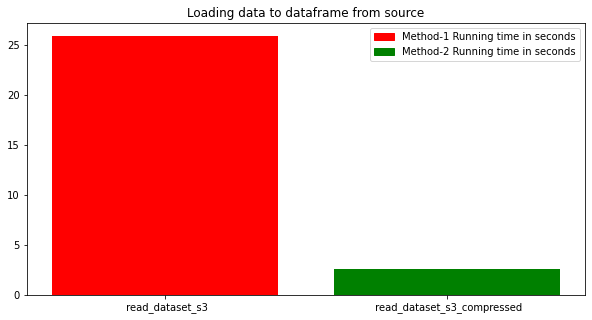

In [180]:
compare_read_data = compare.iloc[0:2,:]
display(compare_read_data)

print()
print()

plt.figure(figsize=(10, 5))
plt.bar(np.array(compare_read_data.iloc[:,1]) , np.array(compare_read_data.iloc[:,3]) , color=['red','green'])
plt.title("Loading data to dataframe from source")
handles = [plt.Rectangle((0,0),1,1, color=color_type) for color_type in ['red', 'green']]
plt.legend(handles, ["Method-1 Running time in seconds", "Method-2 Running time in seconds"], loc='upper right')
plt.show()

To remove duplicates, we tested 2 methods, by using distinct() and by using dropDuplicates(). One always seemed more performant than the other.

,file_name,function_name,description,time_taken
2,process_data,remove_duplicate_records_drop_duplicates,Remove duplicates using drop duplicates,88.368950
3,process_data,remove_duplicate_records_distinct,Remove duplicates using distinct,75.016014


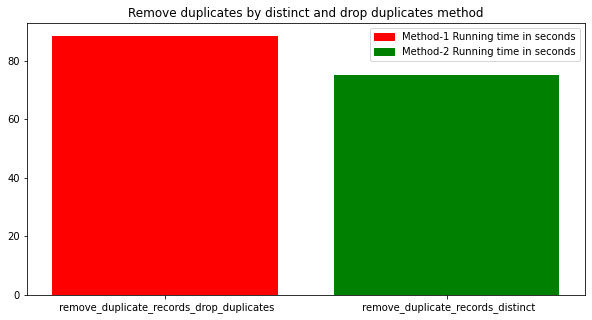

In [181]:
compare_remove_duplicates = compare.iloc[2:4,:]
display(compare_remove_duplicates)

print()
print()

plt.figure(figsize=(10, 5))
plt.bar(np.array(compare_remove_duplicates.iloc[:,1]) , np.array(compare_remove_duplicates.iloc[:,3]) , color=['red','green'])
plt.xticks()
plt.title("Remove duplicates by distinct and drop duplicates method")
handles = [plt.Rectangle((0,0),1,1, color=color_type) for color_type in ['red', 'green']]
plt.legend(handles, ["Method-1 Running time in seconds", "Method-2 Running time in seconds"], loc='upper right')
plt.show()

For processing, we needed to access the attack counts and types. In order to materialize the dataframe to access these values, we had 2 approaches and decided on the better of the two.

,file_name,function_name,description,time_taken
4,process_data,get_attack_counts,Materialize the df to get count of attacks by...,60.536789
5,process_data,get_attack_counts_pandas,Materialize the df to get count of attacks by...,14.454663


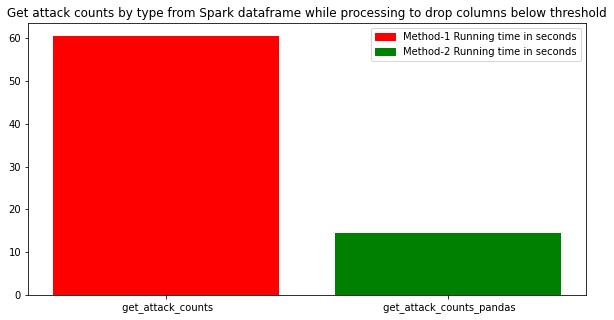

In [182]:
compare_get_attack_counts_from_spark_dataframe = compare.iloc[4:6,:]
display(compare_get_attack_counts_from_spark_dataframe)

print()
print()

plt.figure(figsize=(10, 5))
plt.bar(np.array(compare_get_attack_counts_from_spark_dataframe.iloc[:,1]) , np.array(compare_get_attack_counts_from_spark_dataframe.iloc[:,3]) , color=['red','green'])
plt.xticks()
plt.title("Get attack counts by type from Spark dataframe while processing to drop columns below threshold")
handles = [plt.Rectangle((0,0),1,1, color=color_type) for color_type in ['red', 'green']]
plt.legend(handles, ["Method-1 Running time in seconds", "Method-2 Running time in seconds"], loc='upper right')
plt.show()

Features with only one value in the whole column do not add value to the ML perspective, hence can be dropped for training. There are a couple of ways of doing it, by using distinct or by a custom logic where we pick the first value and filter the values of the column to find uniqueness. The best function was found and the column list was made to directy drop them in the data. If needed, this function can be used to find these columns for a new dataset.

,file_name,function_name,description,time_taken
6,process_data,clean_data_distinct,Remove columns with single value using distinct,190.254669
7,process_data,clean_data_without_distinct,Remove columns with single value without dist...,120.254669


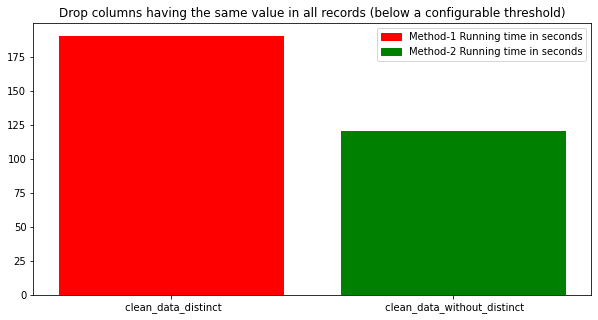

In [183]:
clean_data_without_distinct = compare.iloc[6:8,:]
display(clean_data_without_distinct)

print()
print()

plt.figure(figsize=(10, 5))
plt.bar(np.array(clean_data_without_distinct.iloc[:,1]) , np.array(clean_data_without_distinct.iloc[:,3]) , color=['red','green'])
plt.xticks()
plt.title("Drop columns having the same value in all records (below a configurable threshold)")
handles = [plt.Rectangle((0,0),1,1, color=color_type) for color_type in ['red', 'green']]
plt.legend(handles, ["Method-1 Running time in seconds", "Method-2 Running time in seconds"], loc='upper right')
plt.show()